In [1]:
import xarray
import os
import pandas as pd
import Preprocessing_test

extractor = Preprocessing_test.FileExtractor()

df_dwd_hornsea = extractor.combine_files("data", "dwd_icon_eu_hornsea")
df_dwd_pes = extractor.combine_files("data", "dwd_icon_eu_pes10")
df_dwd_demand = extractor.combine_files("data", "dwd_icon_eu_demand")

ncep_gfs_hornsea = extractor.combine_files("data", "ncep_gfs_hornsea")
ncep_gfs_pes = extractor.combine_files("data", "ncep_gfs_pes10")
ncep_gfs_demand = extractor.combine_files("data", "ncep_gfs_demand")

import numpy as np
import dask.dataframe as dd
import math

preprocesser = Preprocessing_test.Preprocessing()

df_dwd_hornsea = preprocesser.preprocess_geo_data(df_dwd_hornsea)
ncep_gfs_hornsea = preprocesser.preprocess_geo_data(ncep_gfs_hornsea)
df_dwd_pes = preprocesser.preprocess_geo_data(df_dwd_pes)
ncep_gfs_pes = preprocesser.preprocess_geo_data(ncep_gfs_pes)
df_dwd_demand = preprocesser.preprocess_geo_data(df_dwd_demand)
ncep_gfs_demand = preprocesser.preprocess_geo_data(ncep_gfs_demand)

hornsea = preprocesser.merge_weather_stations_data(df_dwd_hornsea, ncep_gfs_hornsea)
demand = preprocesser.merge_weather_stations_data(df_dwd_demand, ncep_gfs_demand)
pes = preprocesser.merge_weather_stations_data(df_dwd_pes, ncep_gfs_pes)

df_energy = extractor.combine_files("data", "Energy_data", ".csv")
df_energy = preprocesser.preprocess_energy_data(df_energy)

merged_hornsea = preprocesser.merge_geo_energy_outage_data(hornsea, df_energy)
merged_pes = preprocesser.merge_geo_energy_outage_data(pes, df_energy)
merged_demand = preprocesser.merge_geo_energy_outage_data(demand, df_energy)

merged_hornsea = preprocesser.add_difference_features(merged_hornsea)
merged_pes = preprocesser.add_difference_features(merged_pes)
merged_demand = preprocesser.add_difference_features(merged_demand)

In [2]:
# import model_utils

# merged_hornsea = pd.read_parquet("./data/preprocessed_hornsea_with_energy.parquet")
# merged_pes = pd.read_parquet("./data/preprocessed_pes_with_energy.parquet")

In [3]:
# import importlib
# import Preprocessing_final
# importlib.reload(Preprocessing_final)



# feature_engineerer_wind = Preprocessing_final.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
# feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

# feature_engineerer_solar = Preprocessing_final.FeatureEngineerer(label = "Wind_MWh_credit")
# feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

# merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
# feature_engineerer_solar_baseline = Preprocessing_final.FeatureEngineerer(label = 'Solar_MWh_credit')
# feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

# merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
# feature_engineerer_wind_baseline = Preprocessing_final.FeatureEngineerer(label = 'Wind_MWh_credit')
# feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

In [4]:
feature_engineerer_wind = Preprocessing_test.FeatureEngineerer(merged_hornsea, label = 'Wind_MWh_credit')
feature_engineerer_solar = Preprocessing_test.FeatureEngineerer(merged_pes, label = 'Solar_MWh_credit')

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing_test.FeatureEngineerer(merged_pes_simple, label = 'Solar_MWh_credit')

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing_test.FeatureEngineerer(merged_hornsea_simple, label = 'Wind_MWh_credit')

### __Wind Energy Forecast__

__baseline__

In [41]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_wind\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_wind\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import warnings

# Unterdrücken von FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_quantils(x, y, quantiles):

    first_month = x.index[0].month  # Den Monat des ersten Datums nehmen
    first_month_data = x[x.index.month == first_month]  # Nur die Daten für den ersten Monat filtern
    filter = len(first_month_data.index)
    
    # 2. Filtere die entsprechenden Zeilen aus `y`

    plt.figure(figsize=(10,6))
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    ax1 = sns.lineplot( x=first_month_data.index, y=y["true"][:filter])

    for quantile in quantiles:
        sns.lineplot(
                    x=first_month_data.index,
                    y=y[str(quantile)][:filter],
                    color='gray',
                    alpha=(1-abs(1-quantile)),
                    label=f'q{quantile}')

    #plt.xlim(x.index.min())
    plt.xlabel('Date/Time')
    plt.ylabel('Generation [MWh]')
    plt.tight_layout()

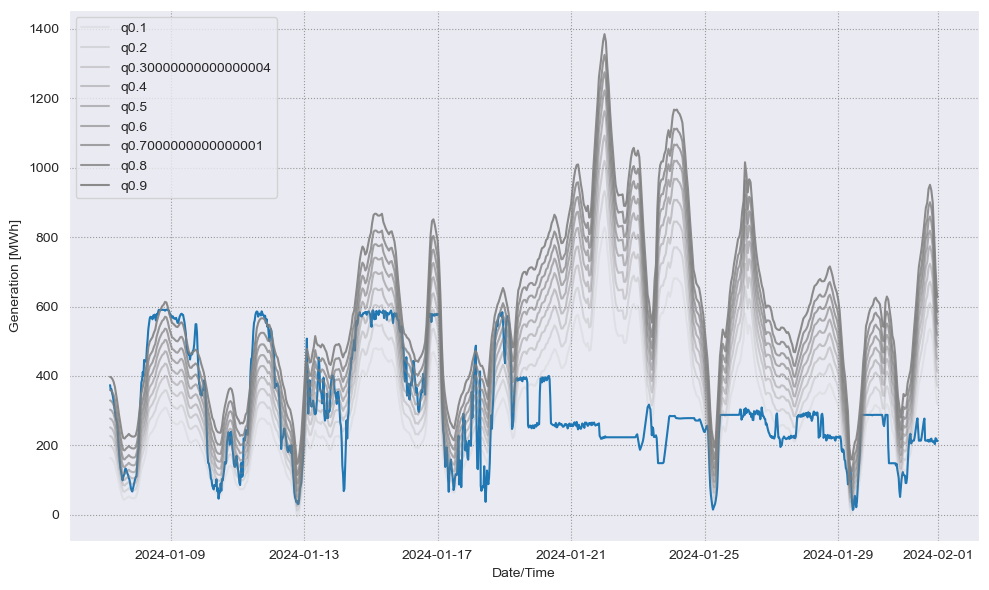

In [44]:
total_rows = len(merged_hornsea)  # Gesamtanzahl der Zeilen im DataFrame
last_10_percent_rows = int(0.1 * total_rows + 1)  # Anzahl der letzten 10% Zeilen

# Extrahieren der letzten 10% des DataFrames
wind_testset = merged_hornsea.tail(last_10_percent_rows)

qr_model_wind.plot_quantils(wind_testset, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [46]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.02,
            "max_depth": 8
        }




xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=75, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:97.01269	Val-quantile:89.28511
[1]	Train-quantile:94.93190	Val-quantile:87.70663
[2]	Train-quantile:92.89940	Val-quantile:86.16924
[3]	Train-quantile:90.91311	Val-quantile:84.65647
[4]	Train-quantile:88.96757	Val-quantile:83.18422
[5]	Train-quantile:87.06570	Val-quantile:81.75633
[6]	Train-quantile:85.20860	Val-quantile:80.37010
[7]	Train-quantile:83.39379	Val-quantile:79.01241
[8]	Train-quantile:81.62795	Val-quantile:77.71049
[9]	Train-quantile:79.90283	Val-quantile:76.44324
[10]	Train-quantile:78.21772	Val-quantile:75.19872
[11]	Train-quantile:76.56924	Val-quantile:73.99170
[12]	Train-quantile:74.96018	Val-quantile:72.80382
[13]	Train-quantile:73.38772	Val-quantile:71.65592
[14]	Train-quantile:71.85023	Val-quantile:70.52689
[15]	Train-quantile:70.34785	Val-quantile:69.42119
[16]	Train-quantile:68.88658	Val-quantile:68.34707
[17]	Train-quantile:67.45775	Val-quantile:67.29529
[18]	Train-quantile:66.07000	Val-quantile:66.27456
[19]	Train-quantile:64.71493	Val-quantile

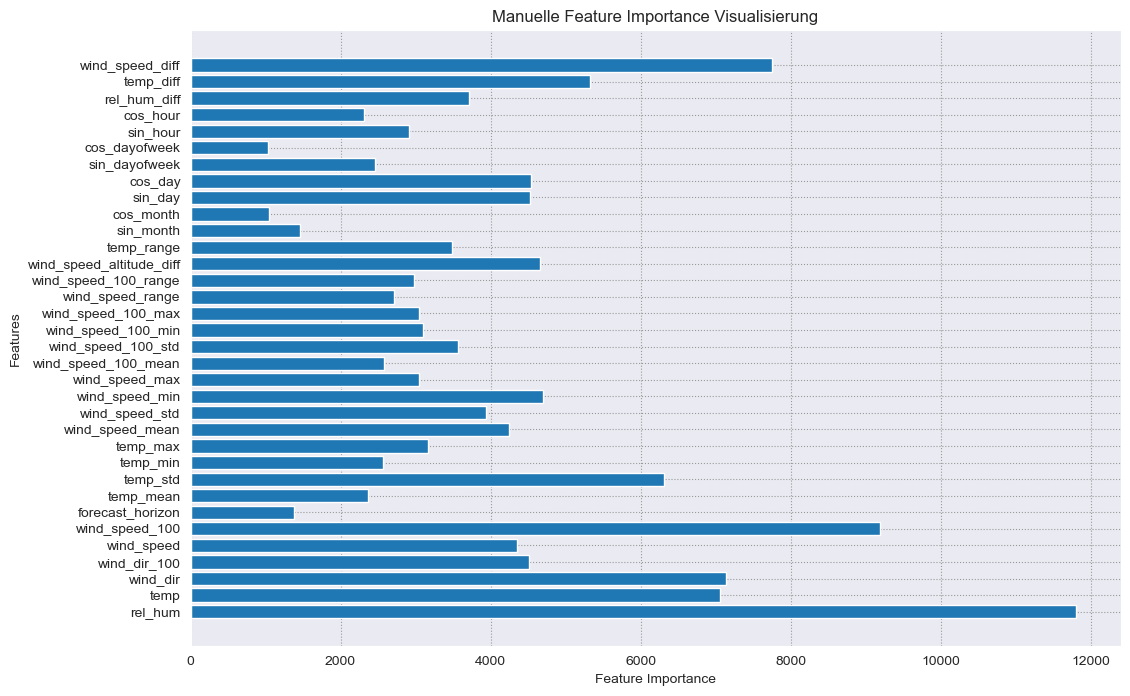

In [47]:
# Feature-Wichtigkeiten abrufen
import matplotlib.pylab as plt

booster = xgboost_model_wind.booster
importance_dict = booster.get_score(importance_type='weight')
# In ein Pandas DataFrame umwandeln für einfache Verarbeitung
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df["feature_name"] = merged_hornsea.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Nach Wichtigkeit sortieren
# importance_df = importance_df.sort_values(by='Index', ascending=False)

# Plotten
plt.figure(figsize=(12, 8))  # Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.title('Manuelle Feature Importance Visualisierung')
plt.show()

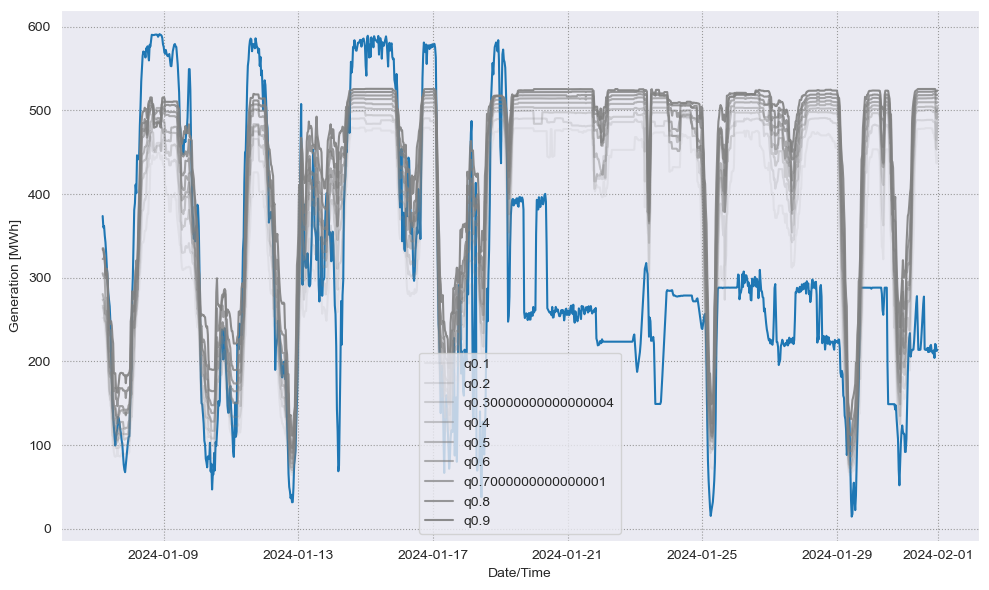

In [48]:
total_rows = len(merged_hornsea)  # Gesamtanzahl der Zeilen im DataFrame
last_10_percent_rows = int(0.1 * total_rows + 1)  # Anzahl der letzten 10% Zeilen

# Extrahieren der letzten 10% des DataFrames
wind_testset = merged_hornsea.tail(last_10_percent_rows)

xgboost_model_wind.plot_quantils(x=wind_testset, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

### __Solar Energy Forecast__

__baseline modell__

In [11]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Saved Quantile Regressor model for quantile 0.1 to qr_model_solar\qr_model_quantile_0.1.pkl
Saved Quantile Regressor model for quantile 0.2 to qr_model_solar\qr_model_quantile_0.2.pkl
Saved Quantile Regressor model for quantile 0.30000000000000004 to qr_model_solar\qr_model_quantile_0.30000000000000004.pkl
Saved Quantile Regressor model for quantile 0.4 to qr_model_solar\qr_model_quantile_0.4.pkl
Saved Quantile Regressor model for quantile 0.5 to qr_model_solar\qr_model_quantile_0.5.pkl
Saved Quantile Regressor model for quantile 0.6 to qr_model_solar\qr_model_quantile_0.6.pkl
Saved Quantile Regressor model for quantile 0.7000000000000001 to qr_model_solar\qr_model_quantile_0.7000000000000001.pkl
Saved Quantile Regressor model for quantile 0.8 to qr_model_solar\qr_model_quantile_0.8.pkl
Saved Quantile Regressor model for quantile 0.9 to qr_model_solar\qr_model_quantile_0.9.pkl
Quantile Regressor Pinball Score: 13.607230504775236


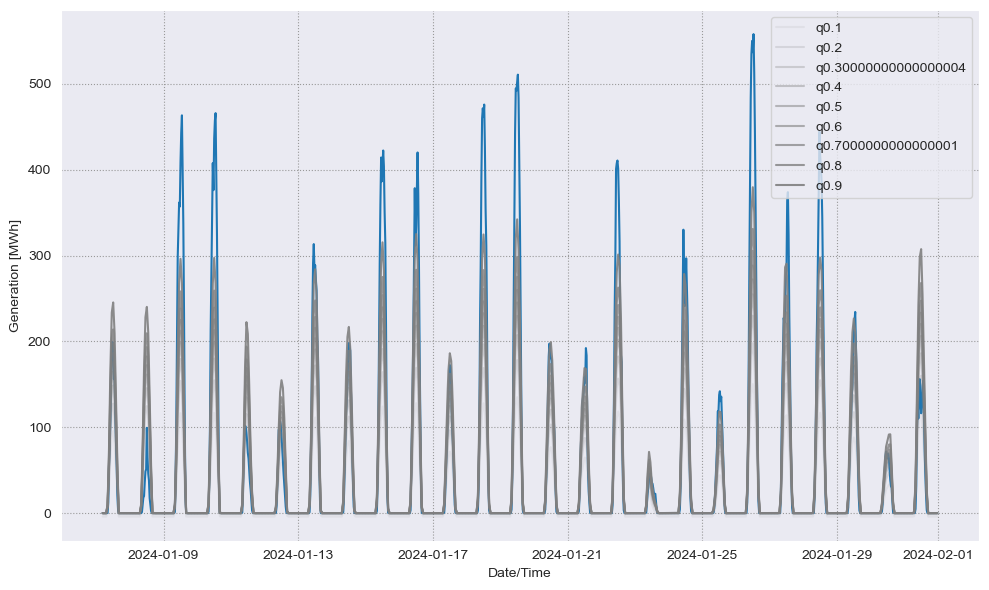

In [12]:
total_rows = len(merged_pes)  # Gesamtanzahl der Zeilen im DataFrame
last_10_percent_rows = int(0.1 * total_rows + 1)  # Anzahl der letzten 10% Zeilen

# Extrahieren der letzten 10% des DataFrames
solar_testset = merged_pes.tail(last_10_percent_rows)

plot_quantils(x=solar_testset, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [13]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.13515	Val-quantile:92.39949
[1]	Train-quantile:42.29184	Val-quantile:88.13729
[2]	Train-quantile:40.54912	Val-quantile:84.14312
[3]	Train-quantile:38.89848	Val-quantile:80.30528
[4]	Train-quantile:37.31716	Val-quantile:76.64144
[5]	Train-quantile:35.80335	Val-quantile:73.11867
[6]	Train-quantile:34.35909	Val-quantile:69.76359
[7]	Train-quantile:32.98317	Val-quantile:66.56863
[8]	Train-quantile:31.66048	Val-quantile:63.54328
[9]	Train-quantile:30.40100	Val-quantile:60.65396
[10]	Train-quantile:29.19980	Val-quantile:57.91469
[11]	Train-quantile:28.06596	Val-quantile:55.29548
[12]	Train-quantile:26.97471	Val-quantile:52.83934
[13]	Train-quantile:25.94129	Val-quantile:50.50737
[14]	Train-quantile:24.95708	Val-quantile:48.31265
[15]	Train-quantile:24.01307	Val-quantile:46.22179
[16]	Train-quantile:23.12180	Val-quantile:44.20001
[17]	Train-quantile:22.27242	Val-quantile:42.36014
[18]	Train-quantile:21.46098	Val-quantile:40.56213
[19]	Train-quantile:20.68992	Val-quantile

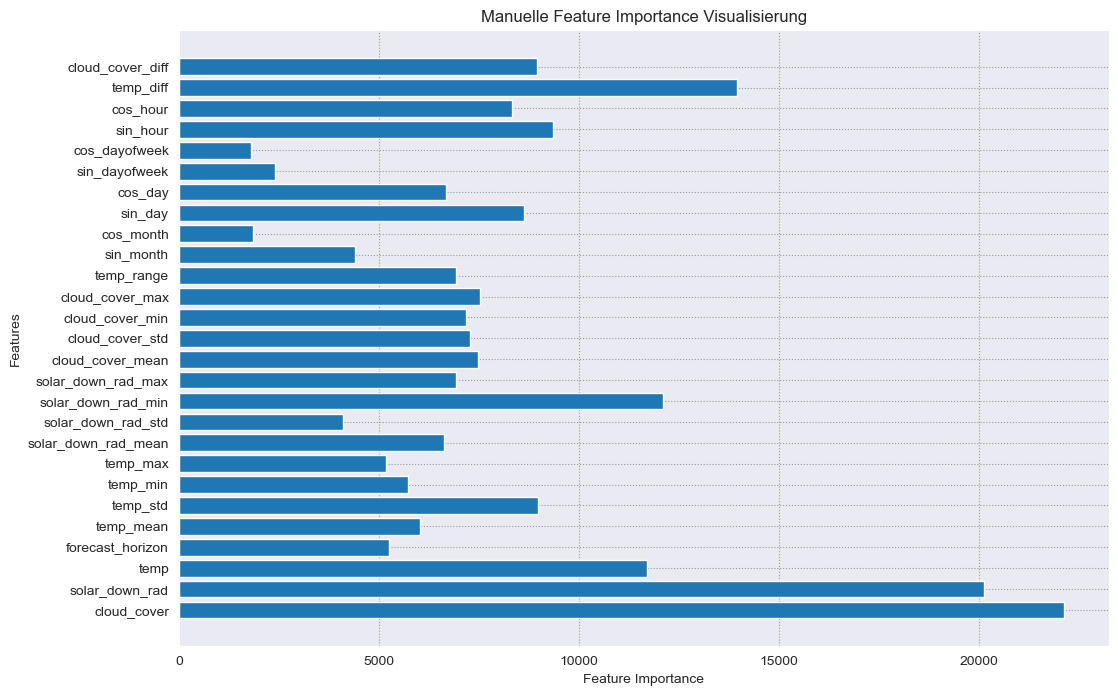

In [14]:
# Feature-Wichtigkeiten abrufen
import matplotlib.pylab as plt

booster = xgboost_model_solar.booster
importance_dict = booster.get_score(importance_type='weight')

# In ein Pandas DataFrame umwandeln für einfache Verarbeitung
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df["feature_name"] = merged_pes.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Nach Wichtigkeit sortieren
# importance_df = importance_df.sort_values(by='Index', ascending=False)

# Plotten
plt.figure(figsize=(12, 8))  # Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.title('Manuelle Feature Importance Visualisierung')
plt.show()

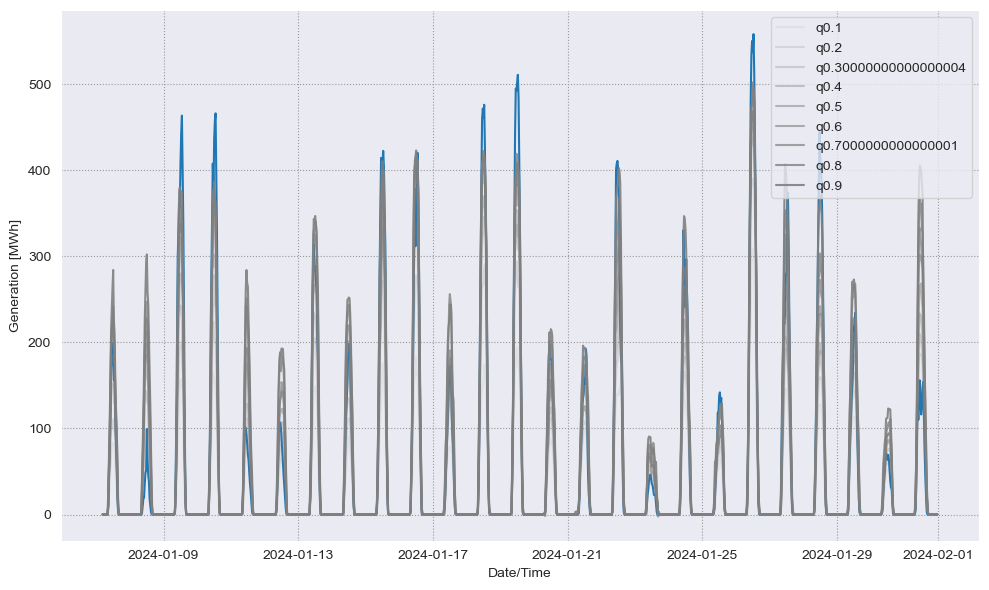

In [15]:
total_rows = len(merged_pes)  # Gesamtanzahl der Zeilen im DataFrame
last_10_percent_rows = int(0.1 * total_rows + 1)  # Anzahl der letzten 10% Zeilen

# Extrahieren der letzten 10% des DataFrames
solar_testset = merged_pes.tail(last_10_percent_rows)

plot_quantils(x=solar_testset, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

### __Lightgbm implementation__

In [16]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
importlib.reload(model_utils)

quantiles = [x for x in np.arange(0.1, 1.0, 0.1)]
qr_solar_lightgbm = {}
qr_solar_lightgbm["true"] = feature_engineerer_solar.y_test.values
#out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)

for quantile in quantiles:
    print(f"Training for quantile: {quantile}")
    qr_lightgbm = lgb.LGBMRegressor(objective='quantile', alpha=quantile, n_estimators=1000, force_col_wise=True)
    qr_lightgbm.fit(
        feature_engineerer_solar.X_train, 
        feature_engineerer_solar.y_train,
        eval_set=[(feature_engineerer_solar.X_train, feature_engineerer_solar.y_train), 
                  (feature_engineerer_solar.X_val, feature_engineerer_solar.y_val)],
        eval_names=['train', 'valid'],
        eval_metric='quantile',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
    )
    qr_solar_lightgbm[str(quantile)] = qr_lightgbm.predict(feature_engineerer_solar.X_test)

qr_solar_lightgbm_df = pd.DataFrame(qr_solar_lightgbm)
model_utils.pinball_score(qr_solar_lightgbm_df, quantiles=quantiles)

Training for quantile: 0.1
[LightGBM] [Info] Total Bins 5040
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 27
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 5.14861	valid's quantile: 5.4345
[100]	train's quantile: 4.66668	valid's quantile: 5.10018
[150]	train's quantile: 4.66474	valid's quantile: 5.09484
[200]	train's quantile: 4.66473	valid's quantile: 5.09477
[250]	train's quantile: 4.66473	valid's quantile: 5.09477
[300]	train's quantile: 4.66473	valid's quantile: 5.09477
[350]	train's quantile: 4.66473	valid's quantile: 5.09477
[400]	train's quantile: 4.66473	valid's quantile: 5.09477
Early stopping, best iteration is:
[379]	train's quantile: 4.66473	valid's quantile: 5.09477
Training for quantile: 0.2
[LightGBM] [Info] Total Bins 5040
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 27
Training until validation scores don't improve for 50 rounds
[50]	train's qu

7.354711369628847

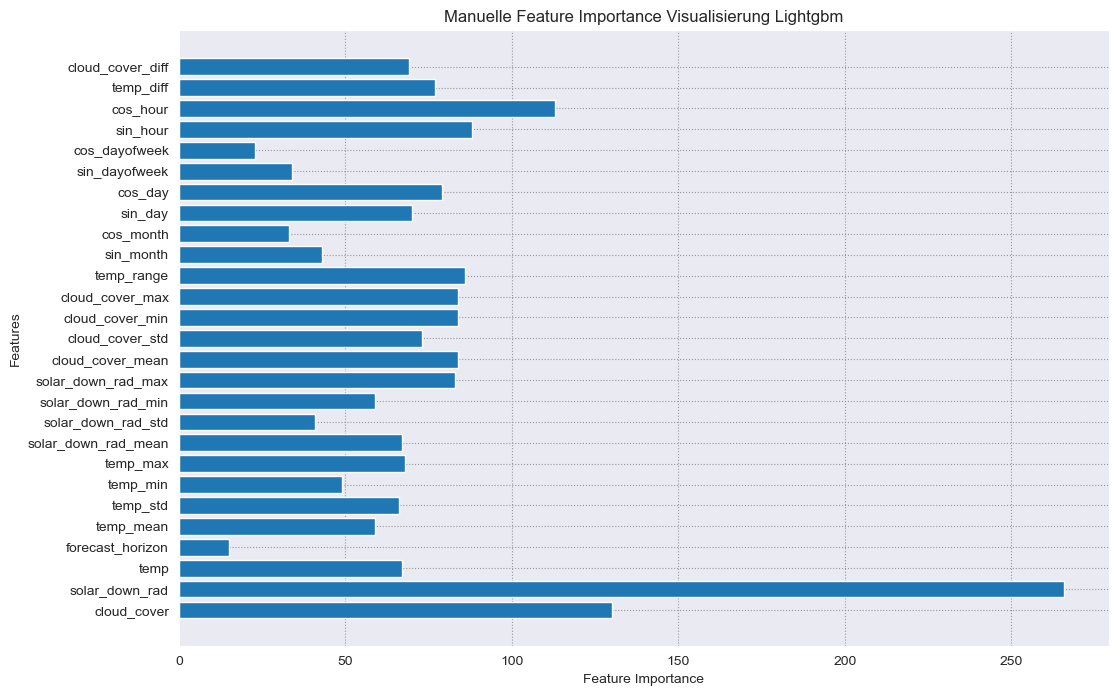

In [17]:
importance_df = pd.DataFrame({
    'Feature': qr_lightgbm.feature_name_,
    'Importance': qr_lightgbm.feature_importances_
})

# Nach Wichtigkeit sortieren
#importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df["feature_name"] = merged_pes.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Plotten der Feature Importance
plt.figure(figsize=(12, 8))  # Plot-Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Manuelle Feature Importance Visualisierung Lightgbm')
plt.grid(True)
plt.show()

In [18]:
quantiles = [x for x in np.arange(0.1, 1.0, 0.1)]
qr_wind_lightgbm = {}
qr_wind_lightgbm["true"] = feature_engineerer_wind.y_test.values
#out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr_lightgbm_wind = lgb.LGBMRegressor(objective='quantile', alpha=quantile, n_estimators=1000, force_col_wise=True, learning_rate=0.3)
    qr_lightgbm_wind.fit(
        feature_engineerer_wind.X_train, 
        feature_engineerer_wind.y_train,
        eval_set=[(feature_engineerer_wind.X_train, feature_engineerer_wind.y_train), 
                  (feature_engineerer_wind.X_val, feature_engineerer_wind.y_val)],
        eval_names=['train', 'valid'],
        eval_metric='quantile',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(30)],
        )
    qr_wind_lightgbm[str(quantile)] = qr_lightgbm_wind.predict(feature_engineerer_wind.X_test)

qr_wind_lightgbm_df = pd.DataFrame(qr_wind_lightgbm)
model_utils.pinball_score(qr_wind_lightgbm_df, quantiles=quantiles)

[LightGBM] [Info] Total Bins 6825
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 34
[LightGBM] [Info] Start training from score 9.724700
Training until validation scores don't improve for 50 rounds
[30]	train's quantile: 10.1098	valid's quantile: 15.6138
[60]	train's quantile: 10.101	valid's quantile: 15.617
Early stopping, best iteration is:
[19]	train's quantile: 10.4499	valid's quantile: 15.5435
[LightGBM] [Info] Total Bins 6825
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 34
[LightGBM] [Info] Start training from score 45.381004
Training until validation scores don't improve for 50 rounds
[30]	train's quantile: 14.1913	valid's quantile: 21.3766
[60]	train's quantile: 13.8605	valid's quantile: 21.4865
Early stopping, best iteration is:
[21]	train's quantile: 14.5109	valid's quantile: 21.264
[LightGBM] [Info] Total Bins 6825
[LightGBM] [Info] Number of data points in the train set: 48168, number of

134.59274464659245

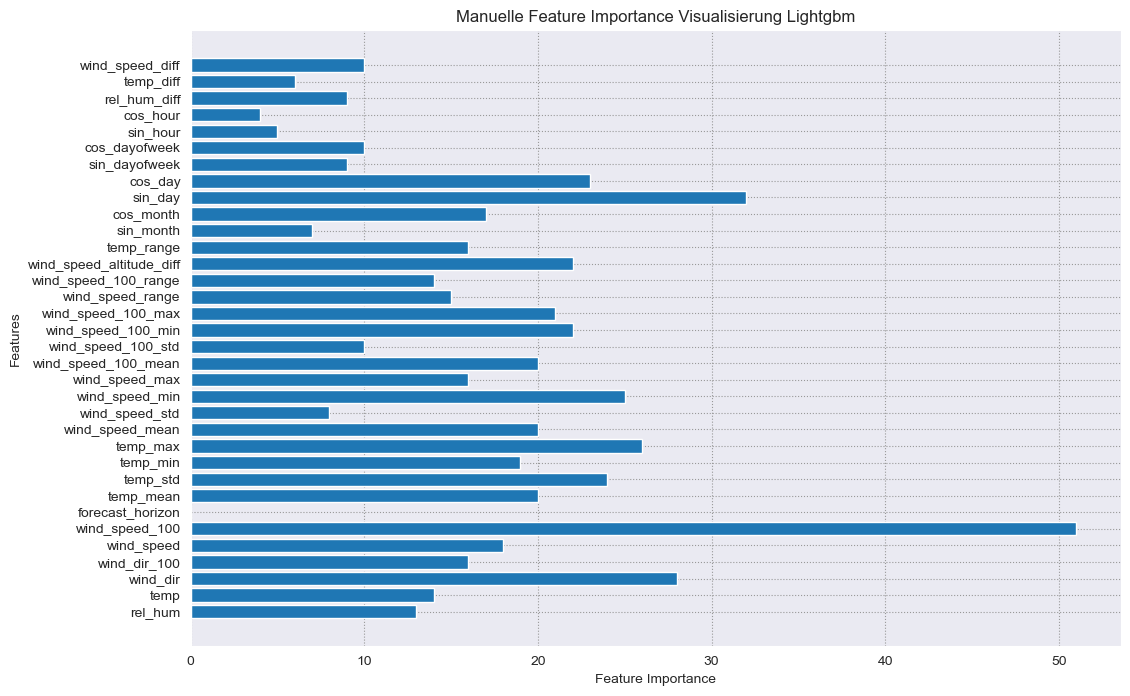

In [19]:
importance_df = pd.DataFrame({
    'Feature': qr_lightgbm_wind.feature_name_,
    'Importance': qr_lightgbm_wind.feature_importances_
})

# Nach Wichtigkeit sortieren
#importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df["feature_name"] = merged_hornsea.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Plotten der Feature Importance
plt.figure(figsize=(12, 8))  # Plot-Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Manuelle Feature Importance Visualisierung Lightgbm')
plt.grid(True)
plt.show()